### Импорт необходимых библиотек и модулей

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = (10, 16)
%matplotlib inline

### Загрузка данных

In [157]:
data = pd.read_csv('site_revenue_data.csv')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Работать с capse-named колонками не очень удобно, поэтому переименуем их:

In [158]:
data.rename(columns={'USER_ID': 'user_id', 'VARIANT_NAME': 'variant_name', 'REVENUE': 'revenue'}, 
            inplace=True)
data.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


### Чистка и трансформация данных

Посмотрим краткую информацию о датасете:

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [160]:
print(f'количество строк в датафрейме: {data.shape[0]}')

количество строк в датафрейме: 10000


Так как в датафрейме в целом 10к строк и в каждом из столбцов 10к non-null значений, то заниматься заполнением/удалением пропусков ненужно, в этом плане все ОК

Посмотрим, насколько вариативны значения по столбцам:

In [161]:
data.nunique()

user_id         6324
variant_name       2
revenue          101
dtype: int64

С `variant_name` все ОК, у нас две группы - контрольная и тестовая, поэтому уникальных значений тоже 2


С `revenue` тоже все OK, ничего необычного в плане количества уникальных значений нет


С `user_id` интереснее: уникальных пользователей 6324, а записей в датафрейме 10000. Значит, некоторые пользователи встречаются в таблице несколько раз. Поэтому нужно сделать группировку по `user_id` и агрегацию по `revenue`

#### Группируем данные по пользователям

Для начала проверим, что каждый пользователь принадлежит только одной группе `variant_name`. Это нужно, во-первых, для правильной агрегации по `revenue`, а во-вторых, необходимо на этапе анализа результатов a/b теста и проверки гипотез

In [162]:
control_users = set(data[data['variant_name'] == 'control']['user_id'])
variant_users = set(data[data['variant_name'] == 'variant']['user_id'])
overlapping_users = control_users & variant_users
print(f'количество пересекающихся клиентов: {len(overlapping_users)}')

количество пересекающихся клиентов: 1541


Видим, что группы пересекаются. Нам необходимо исключить таких клиентов из нашей выборки:

In [163]:
data = data[data['user_id'].map(lambda id: id not in overlapping_users)]
data

,user_id,variant_name,revenue
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


Делаем группировку по  `user_id` и считаем суммарную выручку для каждого пользователя:

In [164]:
data = data.groupby(by=['user_id', 'variant_name'], as_index=False)['revenue'].aggregate(sum)
data

,user_id,variant_name,revenue
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,control,0.0
4780,9993,control,0.0
4781,9995,variant,0.0


Теперь наши данные очищены и подготовлены для анализа

### Анализ данных

#### Посмотрим размеры групп

In [165]:
data.groupby(by='variant_name').size()

variant_name
control    2390
variant    2393
dtype: int64

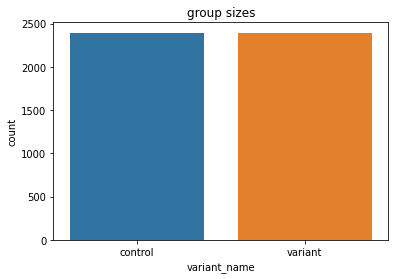

In [166]:
sns.countplot(x=data['variant_name']).set_title('group sizes')
plt.show()

#### Посмотрим на распределение выручки по группам

Text(0.5, 1.0, 'groups distributions')

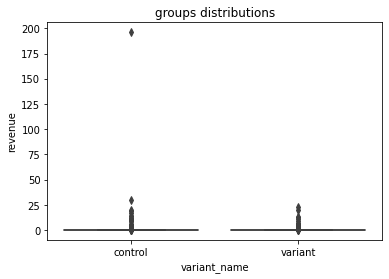

In [167]:
sns.boxplot(x=data['variant_name'], y=data['revenue']).set_title('groups distributions')

In [168]:
data.groupby(by='variant_name')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
variant_name,,,,,,,,
control,2390.0,0.196887,4.172201,0.0,0.0,0.0,0.0,196.01
variant,2393.0,0.074935,0.858207,0.0,0.0,0.0,0.0,23.04


Text(0.5, 1.0, 'groups revenue distribution')

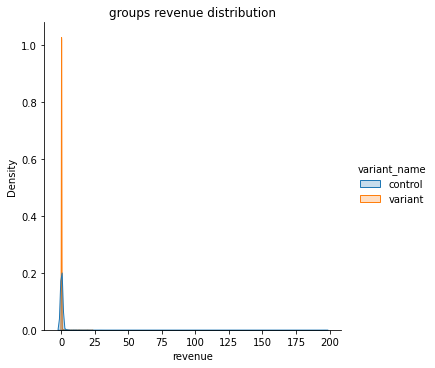

In [169]:
sns.displot(data, x='revenue', hue='variant_name', kind="kde", fill=True)
plt.title('groups revenue distribution')

Видим, что выручка распределена в окрестности нуля в обеих группах. Посмотрим теперь только на тех пользователей, у которых ненулевая выручка:

Text(0.5, 1.0, 'revenue from paying users')

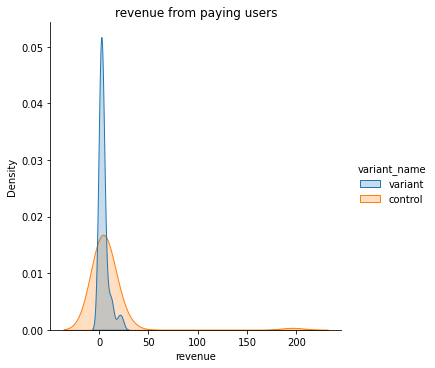

In [170]:
sns.displot(data[data['revenue'] > 0], x='revenue', hue='variant_name', kind="kde", fill=True)
plt.title('revenue from paying users')

Посмотрим, какова доля платящих клиентов и как эти клиенты распределены по группам:

In [171]:
data[data['revenue'] > 0].shape[0] / data.shape[0]

0.020071085093037844

In [172]:
data[data['revenue'] > 0]['variant_name'].value_counts()

control    54
variant    42
Name: variant_name, dtype: int64

Видим, что платящих клиентов достаточно мало

### Проверка гипотез и анализ результатов A/B теста

Отберем для исследования только платящих клиентов:

In [173]:
data = data[data['revenue'] > 0]

Посмотрим среднюю выручку с платящего клиента (ARPPU) в группах:

In [174]:
data.groupby('variant_name')['revenue'].mean()

variant_name
control    8.714074
variant    4.269524
Name: revenue, dtype: float64

Видим, что ARPPU в тестовой группе меньше, чем в контрольной. Исследуем статистическую значимость полученного результата методом проверки гипотезы

Определим размер выборки для проверки гипотезы:

In [175]:
sample_size = min(data['variant_name'].value_counts())
print(f'Размер выборки: {sample_size}')

Размер выборки: 42


Сэмплируем данные из каждой группы:

In [176]:
# Берем все данные по каждой группе отдельно
control_revenue = data[data['variant_name'] == 'control']['revenue'].to_numpy()
variant_revenue = data[data['variant_name'] == 'variant']['revenue'].to_numpy()


# Перемешиваем данные
np.random.shuffle(control_revenue)
np.random.shuffle(variant_revenue)


# Сэмплируем
control_sample = np.random.choice(control_revenue, sample_size)
variant_sample = np.random.choice(variant_revenue, sample_size)


#### Формулируем нулевую и альтернативную гипотезы, выбираем уровень значимости и критерий
$H_{0}$ : $ARPPU_{variant}  \leq ARPPU_{control}$   
$H_{1}$ : $ARPPU_{variant}  > ARPPU_{control}$  
Уровень значимости (&alpha;) : 0.05  
Критерий : Двухвыборочный критерий Стьюдента

Чтобы использовать критерий Стьюдента, нам необходимо удостовериться, что контрольная и тестовая выборки имеют нормальное распределение. Сделаем это:

In [177]:
alpha = 0.05

def shapiro_test(sample):
    _, p_value = stats.shapiro(control_sample)
    if p_value >= alpha:
        return (p_value, True)
    else:
        return (p_value, False)


control_p_value, control_norm = shapiro_test(control_sample)
variant_p_value, variant_norm = shapiro_test(variant_sample)

if control_norm:
    print(f'control p-value: {control_p_value}. \n Контрольная выборка имеет нормальное распределение')
else:
    print(f'control p-value: {control_p_value}. \n Контрольная выборка не распределена нормально')
print('\n')
if variant_norm:
    print(f'variant p-value: {variant_p_value}. \n Тестовая выборка имеет нормальное распределение')
else:
    print(f'variant p-value: {variant_p_value}. \n Тестовая выборка не распределена нормально')


control p-value: 5.870794844188565e-13. 
 Контрольная выборка не распределена нормально


variant p-value: 5.870794844188565e-13. 
 Тестовая выборка не распределена нормально


К сожалению, выборки распределены не нормально, из-за чего критерий Стьюдента мы использовать не можем. Нужен другой критерий, не предполагающий нормального распределения данных. В качестве такого критерия можно взять критерий Манна-Уитни, что мы и сделаем:

In [178]:
_, p_value = stats.mannwhitneyu(control_sample, variant_sample, alternative='less')
if p_value > alpha:
    print('Выручка в тестовой группе меньше, чем в контрольной')
else:
    print('Выручка в тестовой группе больше, чем в контрольной')

Выручка в тестовой группе меньше, чем в контрольной


По итогу проверки гипотезы мы получили, что выручка в контрольной группе была больше, чем в тестовой. Учитывая то, что выборки были одинакового размера, мы можем сделать очевидный вывод о том, что $ARPPU_{variant}  \leq ARPPU_{control}$, то есть нулевая гипотеза верна

### Вывод

В результате анализа имеющихся данных и проверки гипотез мы пришли к выводу, что выручка, как и ARPPU, в контрольной группе оказалась больше, чем в тестовой. Это говорит о том, что изменение, исследуемое в рамках A/B теста, несет отрицательный эффект: в группе, которая не видела новый функционал/дизайн, выручка больше, чем в группе, которая эти изменения видела